In [1]:
pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install gitpython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install itkwidgets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install yacs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
pip install Config


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
pip install validators

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/mop_azure')

# Model training and evaluation on F3 Netherlands dataset

In this notebook, we demonstrate how to train a deep neural network for facies prediction using the F3 Netherlands dataset. The F3 block is located in the North Sea off the shores of Netherlands. The dataset contains 6 classes (of lithostratigraphic units), all of which are of varying thickness (class imbalance). Processed data is available in numpy format as a `401 x 701 x 255` array. The processed F3 data is made publicly available by [Alaudah et al. 2019](https://github.com/yalaudah/facies_classification_benchmark).

We specifically demonstrate a patch-based model approach, where we process a patch of an inline or crossline slice, instead of the entire slice.

## Environment setup

To set up the conda environment and the Jupyter notebook kernel, please follow the instructions in the top-level [README.md](../../../README.md) file.

## Notebook-specific parameters

Now let's set parameters which are required only for this notebook.

We use configuration files to specify experiment configuration, such as hyperparameters used in training and evaluation, as well as other experiment settings. 

This notebook is designed to showcase the patch-based models on Dutch F3 dataset, hence we load the configuration files from that experiment by navigating to the `experiments` folder in the root directory. Each configuration file specifies a different Computer Vision model which is loaded for this notebook.

Modify the `CONFIG_FILE` variable below if you would like to run the experiment using a different configuration file from the same experiment.

For "out-of-the-box" Docker experience we, already pre-poppulated each model configuration file with the correct paramters.

In [3]:

#from botocore.client import Config 

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
CONFIG_FILE = (
    "/content/gdrive/MyDrive/mop_azure/seresnet_unet.yaml"
)

# number of images to score
N_EVALUATE = 20
# demo flag - by default notebook runs in demo mode and only fine-tunes the pre-trained model. Set to False for full re-training.
DEMO = False
# options are test1 or test2 - picks which Dutch F3 test set split to use
TEST_SPLIT = "test1"


# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
import os
#assert os.path.isfile(CONFIG_FILE), "Experiment config file CONFIG_FILE not found on disk"
assert isinstance(N_EVALUATE, int) and N_EVALUATE>0, "Number of images to score has to be a positive integer"
assert isinstance(DEMO, bool), "demo mode should be a boolean"
assert TEST_SPLIT == "test1" or TEST_SPLIT == "test2"

In [4]:
file1 = open('/content/gdrive/MyDrive/mop_azure/patch_train.txt', 'r')
patch_train=file1.read()
patch_train_list=patch_train.splitlines()

In [5]:
file1 = open('/content/gdrive/MyDrive/mop_azure/patch_val.txt', 'r')
patch_val=file1.read()
patch_val_list=patch_val.splitlines()

## Data download and preparation

To download and prepare the F3 data set, please follow the instructions in the top-level [README](../../../README.md) file. Once you have downloaded and prepared the data set, you will find your files in the following directory tree:

```
data
├── splits
├── test_once
│   ├── test1_labels.npy
│   ├── test1_seismic.npy
│   ├── test2_labels.npy
│   └── test2_seismic.npy
└── train
    ├── train_labels.npy
    └── train_seismic.npy
```

We recommend saving the data under `$HOME/data/dutchf3` since this notebook will use that location as the data root. Otherwise, modify the `DATASET.ROOT` field in the configuration file, described next. 


## Library imports

Let's load required libraries - the first step fixes the seeds to obtain reproducible results and the rest of the steps import the libraries

In [6]:
import numpy as np
import torch
import logging
import logging.config
from os import path

import random
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})

from augmentations import*
from utilities import *

import cv2

from resnet_unet import*

from albumentations import Compose, HorizontalFlip, Normalize, PadIfNeeded, Resize
from ignite.contrib.handlers import CosineAnnealingScheduler,LinearCyclicalScheduler,ConcatScheduler
from ignite.handlers import ModelCheckpoint
from ignite.engine import Events
from ignite.engine.engine import Engine
from ignite.metrics import Loss
from ignite.utils import convert_tensor
from toolz import compose
from torch.utils import data
from batch import*
from utils import *
import  logging_handlers


from metrics import*
#from dutchf3utils import*

from tensorboard_handlers import*




from engine import*
from metrics import *
from itkwidgets import view



  
    
   
   
    


 

In [7]:
import yacs.config
with open(CONFIG_FILE, "rt") as f_read:
    config = yacs.config.load_cfg(f_read)


We run test pipelines to test the notebooks, which use [papermill](https://papermill.readthedocs.io/en/latest/). If this notebook is being executed as part of such pipeline, the variables below are overridden. If not, we simply update these variable from a static configuration file specified earlier.

Override parameters in case we use papermill:

In [8]:
# The number of datapoints you want to run in training or validation per batch
# Setting to None will run whole dataset
# useful for integration tests with a setting of something like 3
# Use only if you want to check things are running and don't want to run
# through whole dataset
# The number of epochs to run in training
max_epochs = config.TRAIN.END_EPOCH
max_snapshots = config.TRAIN.SNAPSHOTS
papermill = False
dataset_root = config.DATASET.ROOT
model_pretrained = config.MODEL.PRETRAINED if "PRETRAINED" in config.MODEL.keys() else None

In [17]:
world_size = int(os.environ.get("WORLD_SIZE", 4))
distributed = world_size > 1


#torch.cuda.set_device(4)

# if distributed:
#         # FOR DISTRIBUTED: Set the device according to local_rank.
       

#         #FOR DISTRIBUTED: Initialize the backend. torch.distributed.launch will
#        #provide environment variables, and requires that you use init_method=`env://`.
#        os.environ['MASTER_ADDR'] = 'notebook-f589825e1c364552ae536da887fe5f11-645cdb56cd-pd7zh'
#        os.environ['MASTER_PORT'] = '33319'
       
#        torch.distributed.init_process_group(backend="nccl",init_method="env://",rank=4,world_size=world_size)
        
        

In [18]:
world_size

4

In [9]:
# Fix random seeds, and set CUDNN benchmark mode:
torch.backends.cudnn.benchmark = config.CUDNN.BENCHMARK

# Fix random seeds:
torch.manual_seed(config.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.SEED)
np.random.seed(seed=config.SEED)

For tests we reduce the number of data used by the Jupyter notebook (pending Ignite 0.3.0 where we can just reduce the number of batches per EPOCH).

## F3 data set 

Let's visualize a few sections of the F3 data set. The processed F3 data set is stored as a 3D numpy array. Let's view slices of the data along inline and crossline directions. 

In [10]:
# Load training data and labels
import numpy as np
import os, types 
import pandas as pd 
#from botocore.client import Config 

from albumentations import Compose, HorizontalFlip, Normalize, PadIfNeeded, Resize
from itkwidgets import view


# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
import io
from utilities import*

from data2 import*
from data33 import*



train_seismic = np.load("/content/gdrive/MyDrive/mop_azure/train_seismic.npy")
train_labels = np.load("/content/gdrive/MyDrive/mop_azure/train_labels.npy")

print(f"Number of inline slices: {train_seismic.shape[0]}")
print(f"Number of crossline slices: {train_seismic.shape[1]}")
print(f"Depth dimension : {train_seismic.shape[2]}")
   

Number of inline slices: 401
Number of crossline slices: 701
Depth dimension : 255


In [21]:
view(train_labels, slicing_planes=True)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

Let's plot a __crossline__ slice.

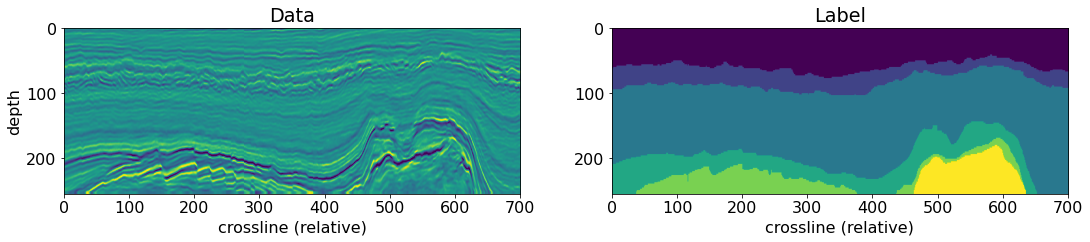

In [22]:
idx = 100
x_in = train_seismic[idx, :, :].swapaxes(0, 1)
x_inl = train_labels[idx, :, :].swapaxes(0, 1)

plot_aline(x_in, x_inl, xlabel="crossline (relative)")

Let's plot an __inline__ slice.

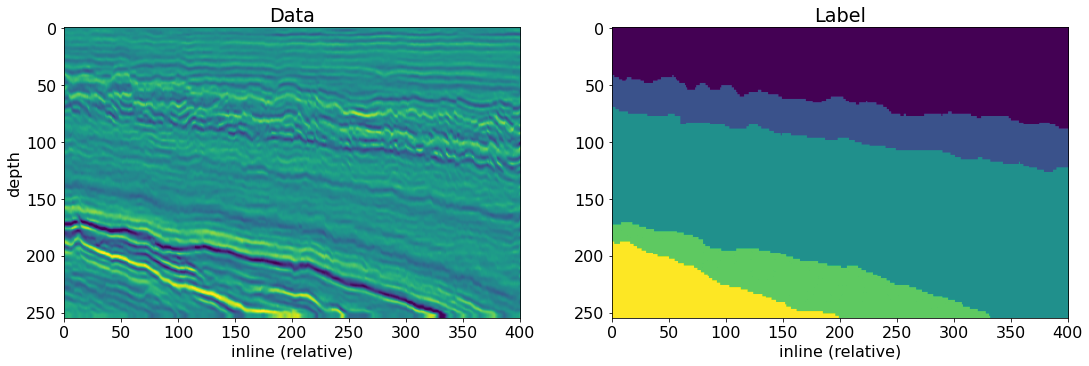

In [23]:
x_cr = train_seismic[:, idx, :].swapaxes(0, 1)
x_crl = train_labels[:, idx, :].swapaxes(0, 1)

plot_aline(x_cr, x_crl, xlabel="inline (relative)")

## Model training

In [11]:
# Set up logging
# load_log_configuration(config.LOG_CONFIG)
# logger = logging.getLogger(__name__)
# logger.debug(config.WORKERS)

scheduler_step = config.TRAIN.END_EPOCH // config.TRAIN.SNAPSHOTS

### Set up data augmentation

Let's define our data augmentation pipeline, which includes basic transformations, such as _data normalization, resizing, and padding_ if necessary. 

In [12]:
# Setup Augmentations
base_aug = Compose(
    [
        Normalize(
            mean=(config.TRAIN.MEAN,), std=(config.TRAIN.STD,), max_pixel_value=1
        ),
        PadIfNeeded(
            min_height=config.TRAIN.PATCH_SIZE,
            min_width=config.TRAIN.PATCH_SIZE,
            border_mode=0,
            always_apply=True,
            #mask_value=255,
            value=0,
        ),
        Resize(
            config.TRAIN.AUGMENTATIONS.RESIZE.HEIGHT,
            config.TRAIN.AUGMENTATIONS.RESIZE.WIDTH,
            always_apply=True,
        ),
        PadIfNeeded(
            min_height=config.TRAIN.AUGMENTATIONS.PAD.HEIGHT,
            min_width=config.TRAIN.AUGMENTATIONS.PAD.WIDTH,
            border_mode=config.OPENCV_BORDER_CONSTANT,
            always_apply=True,
           # mask_value=255,
        ),
    ]
)

if config.TRAIN.AUGMENTATION:
    train_aug = Compose([base_aug, HorizontalFlip(p=0.5)])
    val_aug = base_aug
else:
    raise NotImplementedError(
        "We don't support turning off data augmentation at this time"
    )

### Load the data

For training the model, we will use a patch-based approach. Rather than using entire sections (crosslines or inlines) of the data, we extract a large number of small patches from the sections, and use the patches as our data. This allows us to generate larger set of images for training, but is also a more feasible approach for large seismic volumes. 

We are using a custom patch data loader from our __`deepseismic_interpretation`__ library for generating and loading patches from seismic section data.

In [13]:
from torch.utils import data
scheduler_step = config.TRAIN.END_EPOCH // config.TRAIN.SNAPSHOTS

TrainPatchLoader = get_patch_loader(config)

train_set = TrainPatchLoader(
    config,
    train_seismic,
    train_labels,
    patch_train_list,
    
    "train",
   True,
    train_aug,
)
n_classes = train_set.n_classes
logger.info(train_set)
val_set = TrainPatchLoader(
    config,
    train_seismic,
    train_labels,
    patch_val_list,
    split="val",
    is_transform=True,
    augmentations=val_aug,
)

if papermill:
    train_set = data.Subset(train_set, range(3))
    val_set = data.Subset(val_set, range(3))
elif DEMO:
    val_set = data.Subset(val_set, range(config.VALIDATION.BATCH_SIZE_PER_GPU))

#logger.info(val_set)

train_loader = data.DataLoader(
    train_set,
    batch_size=config.TRAIN.BATCH_SIZE_PER_GPU,
    num_workers=config.WORKERS,
    shuffle=True,
)
val_loader = data.DataLoader(
    val_set,
    batch_size=config.VALIDATION.BATCH_SIZE_PER_GPU,
    num_workers=config.WORKERS,
)



streaming_body_20 = client_3143283556fa48bba0f75447c5588c58.get_object(Bucket='test-donotdelete-pr-bjfmmflhq2ln1r', Key='data2.py')['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
The following code defines the snapshot duration in batches over which we snapshot training models to disk. Variable `scheduler_step` defines how many epochs we have in a snapshot and multiplying that by the number of data points per epoch gives us the number of datapoints which we have per snapshot.

In [14]:
# if we're running in test mode, just run 2 batches
if papermill:
    train_len = 2
# if we're running in demo mode, just run 20 batches to fine-tune the model
elif DEMO:
    train_len = 20
# if we're not in test or demo modes, run the entire loop
else:
    train_len = len(train_loader)

snapshot_duration = scheduler_step * train_len if not papermill else train_len

We also must specify a batch transformation function which allows us to selectively manipulate the data for each batch into the format which model training expects in the next step.

In [15]:
def prepare_batch(batch, device=None, non_blocking=False):
    x, y = batch
    return (
        convert_tensor(x, device=device, non_blocking=non_blocking),
        convert_tensor(y, device=device, non_blocking=non_blocking),
    )


### Set up model training

Next, let's define a model to train, an optimization algorithm, and a loss function. 

Note that the model is loaded from our __`cv_lib`__ library, using the name of the model as specified in the configuration file. To load a different model, either change the `MODEL.NAME` field in the configuration file, or create a new one corresponding to the model you wish to train.

In [16]:
# load a model
#torch.cuda.set_enabled_lms(True)
model = get_seg_model(config)

trained_model = torch.load("/content/gdrive/MyDrive/mop_azure_nb/model_f3_nb_resnet_unet_5562.pt")
trained_model = {k.replace("module.", ""): v for (k, v) in trained_model.items()}
model.load_state_dict(trained_model, strict=True)

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


# Send to GPU if available

# Send to GPU if available
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
model = model.to(device)

# SGD optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=config.TRAIN.MAX_LR,
    momentum=config.TRAIN.MOMENTUM,
    weight_decay=config.TRAIN.WEIGHT_DECAY,
)

# learning rate scheduler
scheduler = CosineAnnealingScheduler(
    optimizer, "lr", config.TRAIN.MAX_LR, config.TRAIN.MIN_LR, cycle_size=snapshot_duration
)

# weights are inversely proportional to the frequency of the classes in the training set
class_weights = torch.tensor(
    config.DATASET.CLASS_WEIGHTS, device=device, requires_grad=False
)

# loss function
criterion = torch.nn.CrossEntropyLoss(
    weight=class_weights, ignore_index=255, reduction="mean"
)

In [ ]:

# torch.cuda.current_device()

In [ ]:
# device

In [ ]:
# sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
# sock.bind(('0.0.0.0', 0))
# print('listening on port:', sock.getsockname()[1])

In [ ]:
# import psutil
    
# ram=psutil.virtual_memory().total
# ram*=9.31*10**-10
# print(ram)

## Training the model

We use [ignite](https://pytorch.org/ignite/index.html) framework to create training and validation loops in our codebase. Ignite provides an easy way to create compact training/validation loops without too much boilerplate code.

In this notebook, we demonstrate the use of ignite on the training loop only. We create a training engine `trainer` that loops multiple times over the training dataset and updates model parameters. 

In [17]:
# create training engine
trainer = create_supervised_trainer(
    model, optimizer, criterion, prepare_batch, device=device
)

#### Logging

We add various events to the trainer, using an event system, that allows us to interact with the engine on each step of the run, such as, when the trainer is started/completed, when the epoch is started/completed and so on. 

Over the next few cells, we use event handlers to add the following events to the training loop:
- log training output
- log and schedule learning rate and
- periodically save model to disk.

In [18]:
# define and create main output directory 
output_dir = config.OUTPUT_DIR+"_nb"
#generate_path(output_dir)

# define main summary writer which logs all model summaries
#summary_writer = create_summary_writer(log_dir=path.join(output_dir, config.LOG_DIR))


In [ ]:
# type(summary_writer)

Next we need to score the model on validation set as it's training. To do this we need to add helper functions to manipulate data into the required shape just as we've done to prepare each batch for training at the beginning of this notebook.

We also set up evaluation metrics which we want to record on the training set.

In [19]:
transform_fn = lambda output_dict: (output_dict["y_pred"].squeeze(), output_dict["mask"].squeeze())
evaluator = create_supervised_evaluator(
    model,
    prepare_batch,
    metrics={
        "nll": Loss(criterion, output_transform=transform_fn),
        "pixacc": pixelwise_accuracy(n_classes, output_transform=transform_fn, device=device),
        "cacc": class_accuracy(n_classes, output_transform=transform_fn,device=device),
        "mca": mean_class_accuracy(n_classes, output_transform=transform_fn,device=device),
        "ciou": class_iou(n_classes, output_transform=transform_fn,device=device),
        "mIoU": mean_iou(n_classes, output_transform=transform_fn,device=device),
    },
    device=device,
)
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

# Logging:
#trainer.add_event_handler(Events.ITERATION_COMPLETED, log_training_output(CONFIG_FILE['PRINT_FREQ']))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, log_lr(optimizer))

# Tensorboard and Logging:

#trainer.add_event_handler(Events.ITERATION_COMPLETED, log_model_output("Training/loss", summary_writer))
#trainer.add_event_handler(Events.ITERATION_COMPLETED, log_model_output("Validation/loss", summary_writer))

# add specific logger which also triggers printed metrics on test set
# @trainer.on(Events.EPOCH_COMPLETED)
# def log_training_results(engine):
#     evaluator.run(train_loader)
#     log_results(engine, evaluator, summary_writer, n_classes, stage="Training")
#     log_metrics(engine, evaluator, stage="Training")

# # add specific logger which also triggers printed metrics on validation set
# @trainer.on(Events.EPOCH_COMPLETED)
# def log_validation_results(engine):
#     evaluator.run(val_loader)
#     log_results(engine, evaluator, summary_writer, n_classes, stage="Validation")
#     log_metrics(engine, evaluator, stage="Validation")

We also checkpoint models and snapshot them to disk with every training epoch.

In [20]:
# add model checkpointing
checkpoint_handler = ModelCheckpoint(
   output_dir,
    "model_f3_nb",
    save_interval=1,
    n_saved=1,
    create_dir=True,
    require_empty=False,
)

trainer.add_event_handler(
    Events.EPOCH_COMPLETED, checkpoint_handler, {config.MODEL.NAME: model}
)

Argument save_interval is deprecated and should be None. This argument will be removed in 0.5.0.Please, use events filtering instead, e.g. Events.ITERATION_STARTED(every=1000)


Start the training engine run.

In [ ]:
torch.cuda.device_count()

In [ ]:
trainer.run(train_loader, max_epochs=config.TRAIN.END_EPOCH, epoch_length=train_len, seed = config.SEED)

Argument seed is deprecated. It will be removed in 0.5.0. Please, use torch.manual_seed or ignite.utils.manual_seed
nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.


## Tensorboard
Using tensorboard for monitoring runs can be quite enlightening. Just ensure that the appropriate port is open on the VM so you can access it. Below we have the command for running tensorboard in your notebook. You can as easily view it in a seperate browser window by pointing the browser to the appropriate location and port.

In [ ]:
if not papermill:
    %load_ext tensorboard

In [ ]:
if not papermill:
    %tensorboard --logdir $output_dir --port 9001 --host 0.0.0.0

## Evaluation

We will next evaluate the performance of the model by looking at how well it predicts facies labels on samples from the test set.

We will use the following evaluation metrics:

- Pixel Accuracy (PA)
- Class Accuracy (CA)
- Mean Class Accuracy (MCA)
- Frequency Weighted intersection-over-union (FW IoU)
- Mean IoU (MIoU)

You have an option here to use either the pre-trained model which we provided for you or to use the model which we just fine-tuned in this notebook. By default, we use the fine-tuned model, but you can change that in the cell below.

In [ ]:
# use the model which we just fine-tuned
if "hrnet" in CONFIG_FILE['MODEL']['NAME']:
    model_snapshot_name = f"model_f3_nb_seg_hrnet_{train_len}.pth"
elif "resnet" in CONFIG_FILE['MODEL']['NAME']:    
    model_snapshot_name = f"model_f3_nb_resnet_unet_{train_len}.pth"
else:
    raise NotImplementedError("We don't support testing this model in this notebook yet")
    
opts = {"TEST.MODEL_PATH": path.join(output_dir, model_snapshot_name)}
# uncomment the line below to use the pre-trained model instead
# opts = ["TEST.MODEL_PATH", config.MODEL.PRETRAINED]

CONFIG_FILE=CONFIG_FILE|opts

In [ ]:
trained_model = torch.load(CONFIG_FILE["TEST"]["MODEL_PATH"])
trained_model = {k.replace("module.", ""): v for (k, v) in trained_model.items()}
model.load_state_dict(trained_model, strict=True)
model = model.to(device)

Next we load the test data and define the augmentations on it. 

In [ ]:
# Augmentation
# augment entire sections with the same normalization
section_aug = Compose(
    [Normalize(mean=(CONFIG_FILE['TRAIN']['MEAN']), std=(CONFIG_FILE['TRAIN']['STD']), max_pixel_value=1,)]
)

# augment each patch and not the entire sectiom which the patches are taken from
patch_aug = Compose(
    [
        Resize(
            CONFIG_FILE['TRAIN']['AUGMENTATIONS']['RESIZE']['HEIGHT'],
            CONFIG_FILE['TRAIN']['AUGMENTATIONS']['RESIZE']['WIDTH'],
            always_apply=True,
        ),
        PadIfNeeded(
            min_height=CONFIG_FILE['TRAIN']['AUGMENTATIONS']['PAD']['HEIGHT'],
            min_width=CONFIG_FILE['TRAIN']['AUGMENTATIONS']['PAD']['WIDTH'],
            border_mode=CONFIG_FILE['OPENCV_BORDER_CONSTANT'],
            always_apply=True,
            mask_value=255,
        ),
    ]
)

# Process test data
pre_processing = compose_processing_pipeline(CONFIG_FILE['TRAIN']['DEPTH'], aug=patch_aug)
output_processing = output_processing_pipeline(CONFIG_FILE)

# Select the test split
split = TEST_SPLIT
streaming_body_26 = client_314328556fa48bba0f75447c5588c58.get_object(Bucket='test-donotdelete-pr-bjfmmflhq2ln1r', Key='test1_labels.npy')['Body']
with io.BytesIO(streaming_body_26.read()) as f:
    # rewind the file
    f.seek(0)
    labels = np.load(f)
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/





# section_file = path.join(CONFIG_FILE['DATASET']['ROOT'], "splits", "section_" + split + ".txt")
# write_section_file(labels, section_file, CONFIG_FILE)

# Load test data
TestSectionLoader = get_test_loader(CONFIG_FILE)
test_set = TestSectionLoader(
    CONFIG_FILE, split=split, is_transform=True, augmentations=section_aug
)
# needed to fix this bug in pytorch https://github.com/pytorch/pytorch/issues/973
# one of the workers will quit prematurely
torch.multiprocessing.set_sharing_strategy("file_system")
test_loader = data.DataLoader(
    test_set, batch_size=1, num_workers=CONFIG_FILE['WORKERS'], shuffle=False
)

### Predict segmentation mask on the test data

For demonstration purposes and efficiency, we will only use a subset of the test data to predict segmentation mask on. More precisely, we will score `N_EVALUATE` images. If you would like to evaluate more images, set this variable to the desired number of images.

In [ ]:
CLASS_NAMES = [
    "upper_ns",
    "middle_ns",
    "lower_ns",
    "rijnland_chalk",
    "scruff",
    "zechstein",
]

n_classes = len(CLASS_NAMES)

# keep only N_EVALUATE sections to score
test_subset = random.sample(list(test_loader), N_EVALUATE)

results = list()
running_metrics_split = runningScore(n_classes)

# testing mode
with torch.no_grad():
    model.eval()
    # loop over testing data
    for i, (images, labels) in enumerate(test_subset):
        logger.info(f"split: {split}, section: {i}")
        outputs = utilities.patch_label_2d(
            model,
            images,
            pre_processing,
            output_processing,
            CONFIG_FILE['TRAIN']['PATCH_SIZE'],
            CONFIG_FILE['TEST']['TEST_STRIDE'],
            CONFIG_FILE['VALIDATION']['BATCH_SIZE_PER_GPU'],
            device,
            n_classes,
        )

        pred = outputs.detach().max(1)[1].numpy()
        gt = labels.numpy()
        
        # update evaluation metrics
        running_metrics_split.update(gt, pred)
        
        # keep ground truth and result for plotting
        results.append((np.squeeze(gt), np.squeeze(pred)))

Let's view the obtained metrics on this subset of test images. Note that we trained our model for for a small number of epochs, for demonstration purposes, so the performance results here are not meant to be representative. 

The performance exceed the ones shown here when the models are trained properly. For the full report on benchmarking performance results, please refer to the [README.md](../../../README.md) file.

In [ ]:
# get scores
score, _ = running_metrics_split.get_scores()

# Log split results
print(f'Pixel Acc: {score["Pixel Acc: "]:.3f}')
for cdx, class_name in enumerate(CLASS_NAMES):
    print(f'  {class_name}_accuracy {score["Class Accuracy: "][cdx]:.3f}')

print(f'Mean Class Acc: {score["Mean Class Acc: "]:.3f}')
print(f'Freq Weighted IoU: {score["Freq Weighted IoU: "]:.3f}')
print(f'Mean IoU: {score["Mean IoU: "]:0.3f}')

### Visualize predictions

Let's visualize the predictions on entire test sections. Note that the crosslines and inlines have different dimensions, however we were able to use them jointly for our network training and evaluation, since we were using smaller patches from the sections, whose size we can control via hyperparameter in the experiment configuration file. 

In [ ]:
fig = plt.figure(figsize=(15, 50))
# only plot a few images
nplot = min(N_EVALUATE, 10)
for idx in range(nplot):
    # plot actual
    plt.subplot(nplot, 2, 2 * (idx + 1) - 1)
    plt.imshow(results[idx][0])
    # plot predicted
    plt.subplot(nplot, 2, 2 * (idx + 1))
    plt.imshow(results[idx][1])
    
f_axes = fig.axes
_ = f_axes[0].set_title("Actual")
_ = f_axes[1].set_title("Predicted")
fig.savefig("plot_predictions.png")

In [ ]:

project = Project.access(project_id="c6a4b66c-4ee6-484f-b840-8b151cd28d70",auth_token="p-fe26f9e6f6fe9da2ba757c5ef557c779a2df5769")
        # reading the file names for split
txt_path = path.join("patch_" + "train" + ".txt")
my_file = project.get_file(txt_path)

# Read the CSV data file into a pandas DataFrame

patch_list = tuple(open(my_file.read()),'r')

In [ ]:
patch_list

In [ ]:
f= open("/home/wsuser/work/guru99.txt","w+")
f.write("DD")
f.close()


In [ ]:
#    C:\Users\username\AppData\Roaming\IBM Watson Studio\projects\project-name\assets\notebook

import glob
print(glob.glob("/home/wsuser/work/*"))

In [ ]:
import os
os.listdir('/home/wsuser/work/')

In [ ]:
import socket    
host = socket.getfqdn()    
addr = socket.gethostbyname(host)
print(f"Your ip is {addr}")

In [ ]:

sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.bind((addr, 0))
print('listening on port:', sock.getsockname()[1])

In [ ]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]

In [ ]:
torch.cuda.device_count()
